# This notebook demonstrates reconstruction techniques.
## Algos explored : k-means, DBSCAN, CLUE-like clustering
## Cases considered: diphotons 100cms apart to 10 cms apart with and without noise 

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [2]:
import numpy as np
from tqdm import tqdm as tqdm
import matplotlib.pyplot as plt
import os
import os.path as osp

## Load data array with format   [0: event no,  1: x,  2: y,  3: z, 4: layer, 5: energy]

In [3]:
### format evno, x, y z, l, e
dipho25 = np.load("dipho_10.npy") #dipho_100noise, dipho_100, dipho_10

## Plot events

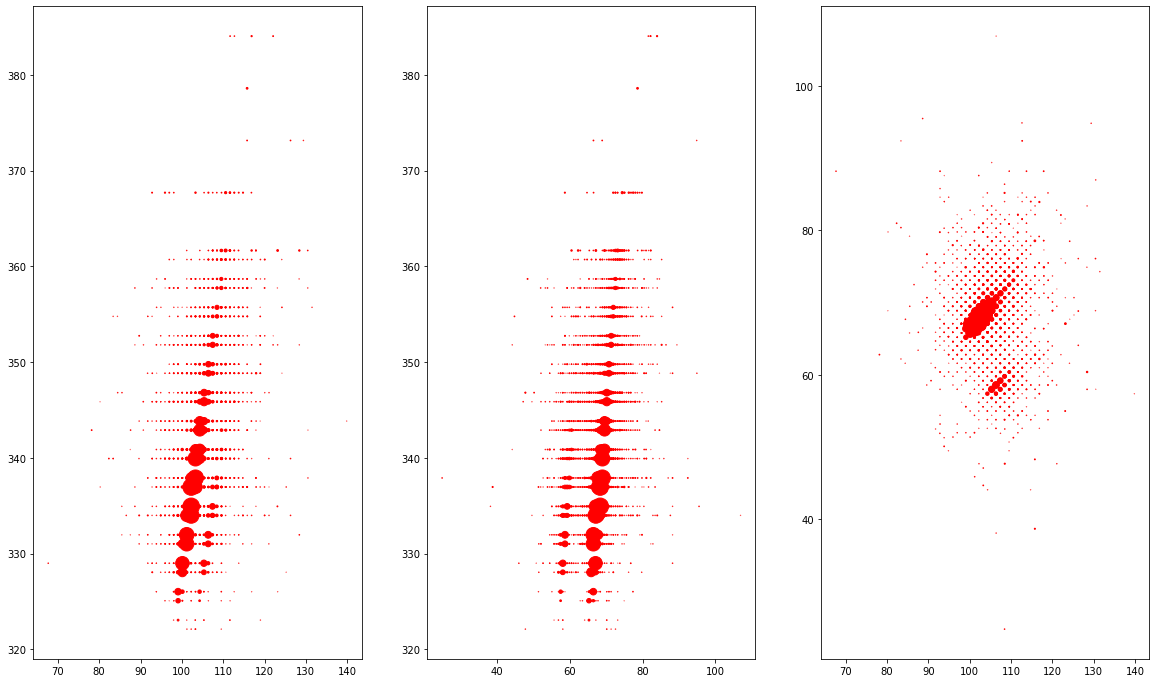

In [4]:
for evt in np.unique(dipho25[:,0]):
    hitarray = dipho25[dipho25[:,0] == evt][:,[1,2,3,5]] ## select x,y,z,E
    fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(20,12))
    ax0.scatter(hitarray[:,0],hitarray[:,2],s=hitarray[:,3]*10,c='r')
    ax1.scatter(hitarray[:,1],hitarray[:,2],s=hitarray[:,3]*10,c='r')
    ax2.scatter(hitarray[:,0],hitarray[:,1],s=hitarray[:,3]*10,c='r')
    break

## Select a test event

In [5]:
## select a test event from input arrays
hitarray = dipho25[dipho25[:,0] == 0][:,[1,2,3,5]]

## Try k-means clustering

(2856,)
clusters with counts (array([0, 1, 2], dtype=int32), array([1043, 1138,  675]))


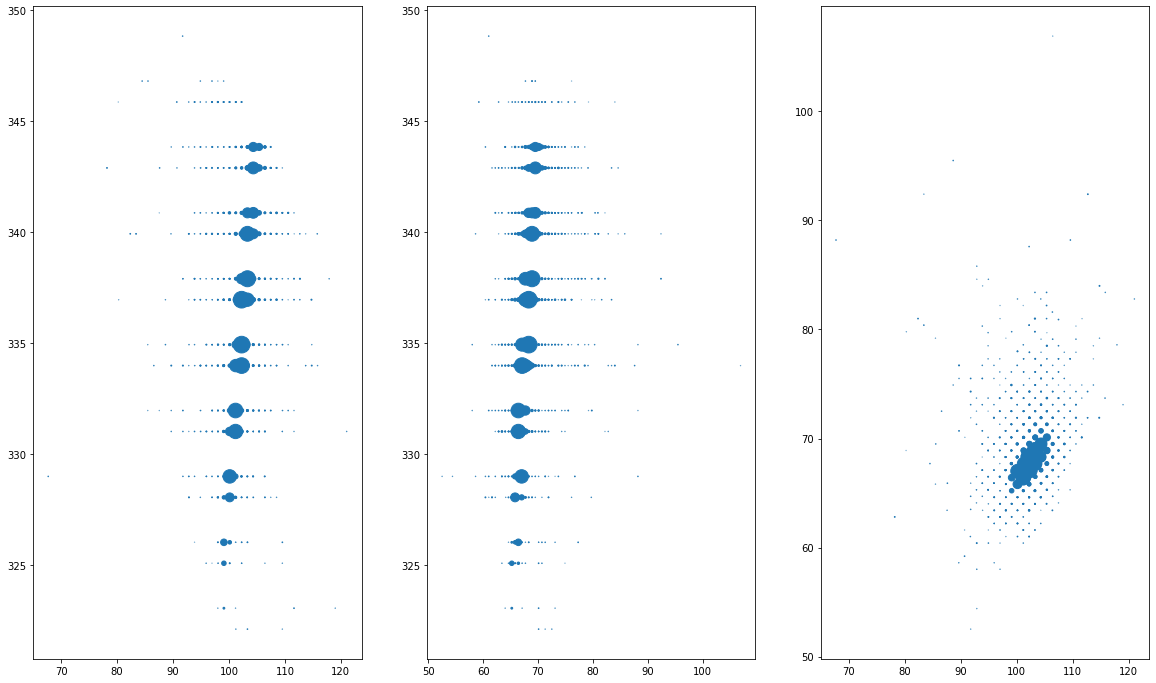

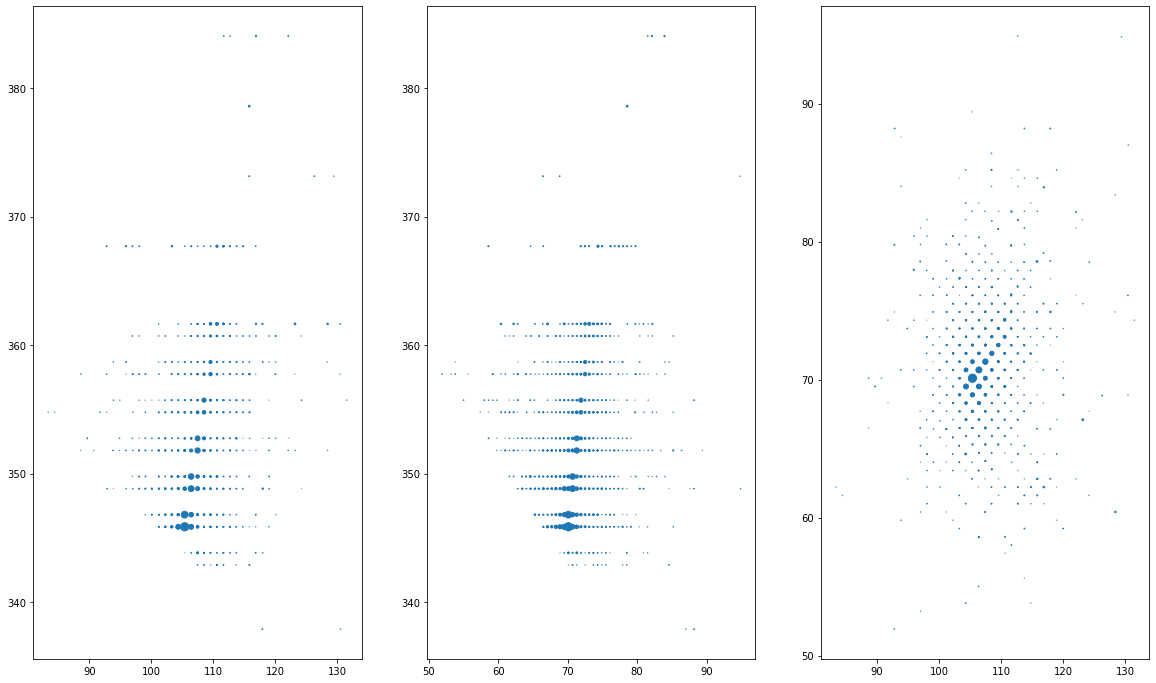

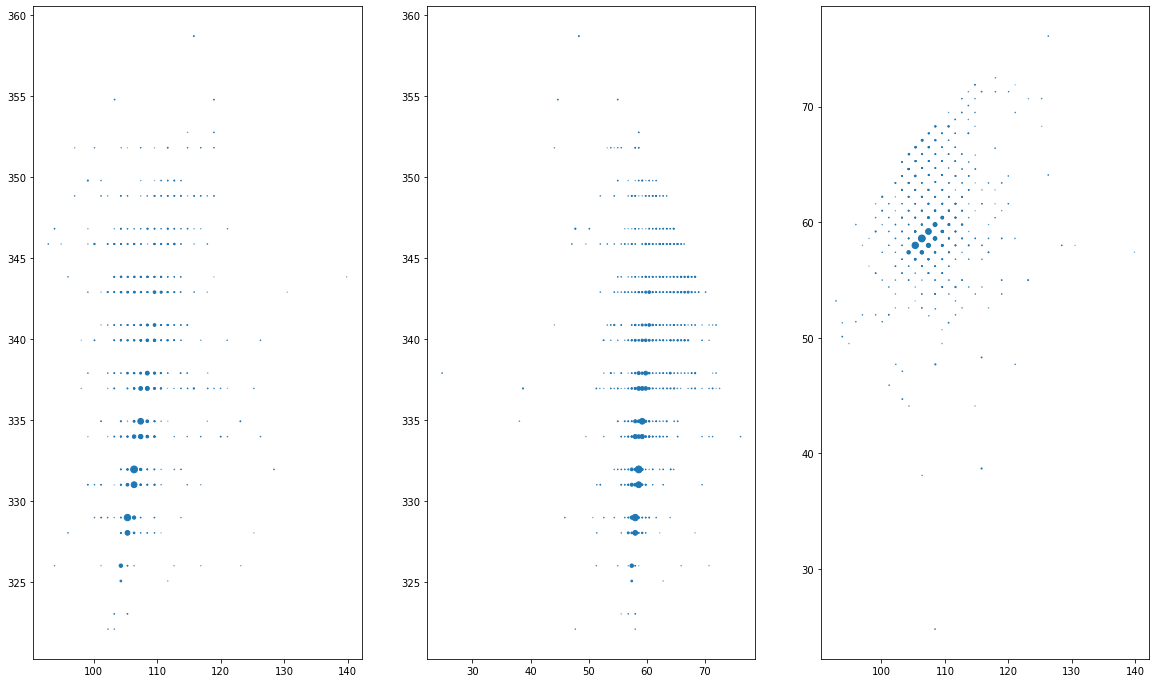

In [6]:
## test k-Means clustering
from sklearn.cluster import KMeans

## use x,y,z coordinated to find nearest neighbours
kmeans = KMeans(n_clusters=3,random_state=0).fit(hitarray[:,0:3]) 
print(kmeans.labels_.shape)
print("clusters with counts",np.unique(kmeans.labels_,return_counts=True))
for i in np.unique(kmeans.labels_):
    fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(20,12))
    ax0.scatter(hitarray[np.where(kmeans.labels_ == i)][:,0],hitarray[np.where(kmeans.labels_ == i)][:,2],s=hitarray[np.where(kmeans.labels_ == i)][:,3]*10)#,c='r')
    ax1.scatter(hitarray[np.where(kmeans.labels_ == i)][:,1],hitarray[np.where(kmeans.labels_ == i)][:,2],s=hitarray[np.where(kmeans.labels_ == i)][:,3]*10)#,c='r')
    ax2.scatter(hitarray[np.where(kmeans.labels_ == i)][:,0],hitarray[np.where(kmeans.labels_ == i)][:,1],s=hitarray[np.where(kmeans.labels_ == i)][:,3]*10)#,c='r')
    
    
    

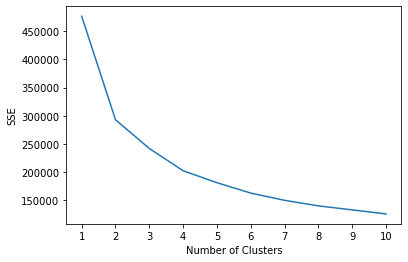

In [7]:
## sum of squared distance
ssd = []
for k in range(1, 11): ## loop over nclusters
    kmeans = KMeans(n_clusters=k,random_state=0)
    kmeans.fit(hitarray[:,0:3])
    ssd.append(kmeans.inertia_)

plt.plot(range(1, 11), ssd)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

## Try DBSCAN

(2856,)
clusters with counts (array([-1,  0]), array([ 269, 2587]))


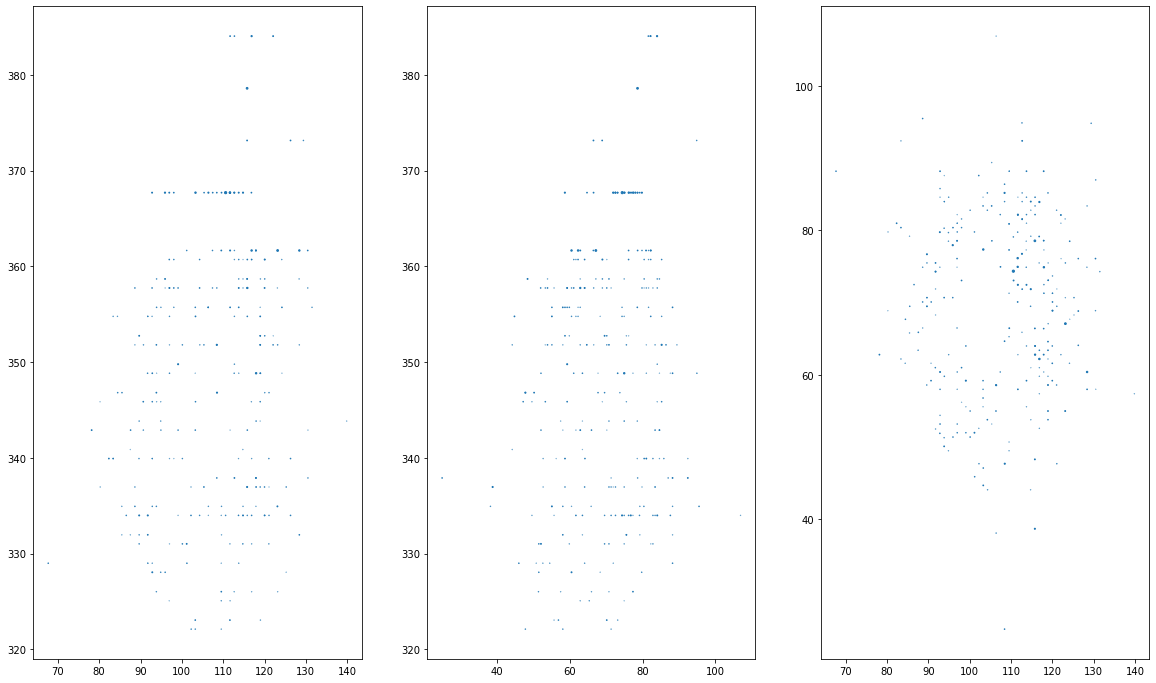

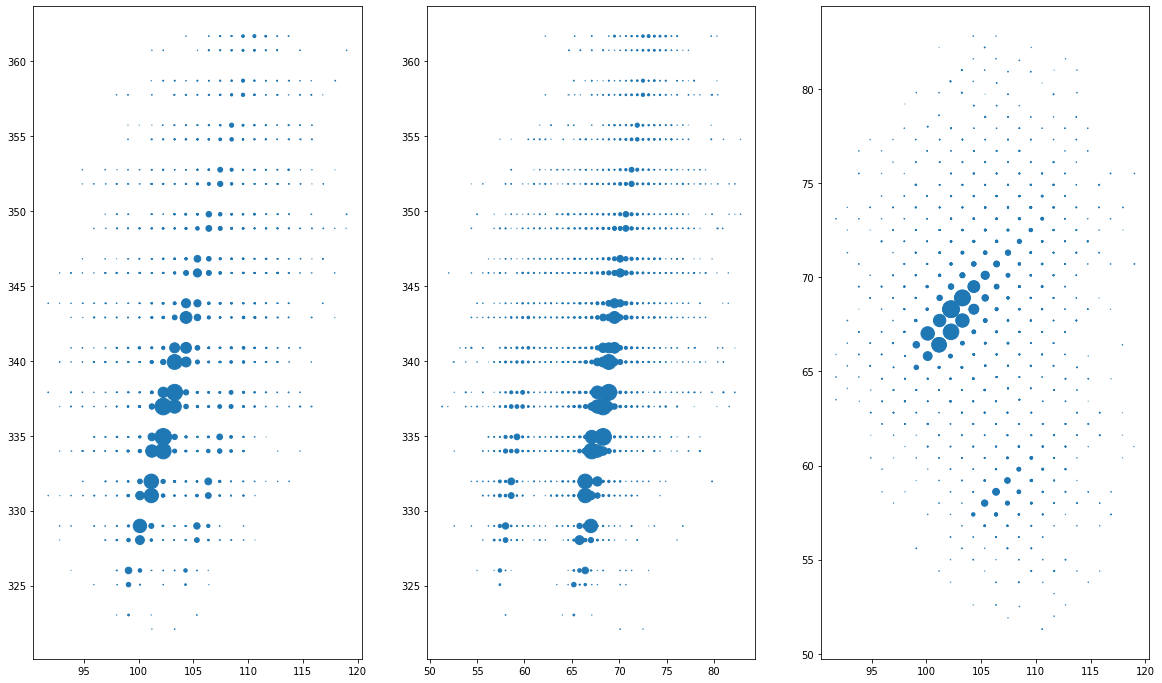

In [8]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=5, min_samples=50).fit(hitarray[:,0:3])

print(clustering.labels_.shape)
print("clusters with counts",np.unique(clustering.labels_,return_counts=True))

for i in np.unique(clustering.labels_):
    fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(20,12))
    ax0.scatter(hitarray[np.where(clustering.labels_ == i)][:,0],hitarray[np.where(clustering.labels_ == i)][:,2],s=hitarray[np.where(clustering.labels_ == i)][:,3]*10)#,c='r')
    ax1.scatter(hitarray[np.where(clustering.labels_ == i)][:,1],hitarray[np.where(clustering.labels_ == i)][:,2],s=hitarray[np.where(clustering.labels_ == i)][:,3]*10)#,c='r')
    ax2.scatter(hitarray[np.where(clustering.labels_ == i)][:,0],hitarray[np.where(clustering.labels_ == i)][:,1],s=hitarray[np.where(clustering.labels_ == i)][:,3]*10)#,c='r')
    
    
    

# Try clustering by computing energy densities

### Calculate energy densities for eact hit

In [9]:
##### for nonoise 10cms
hitprops={} ## dict of densities for each hit and index of neighbours used in calculation
print(hitarray.shape)

## loop over all rechits
for rh in tqdm(range(hitarray.shape[0]),desc="calculating densities"):
    props=[]
    ## calculate dist of all nighbours to this rechit
    dist= np.linalg.norm((hitarray[:,0:3] - hitarray[rh][0:3]),axis=1)
    ## distance cut for being neighbour
    distN = 3.0 ### 3.0 works
    ## array of neighbour indices
    Nidx = np.where((dist > 0) & (dist < distN))[0]
    
    hitprops[rh] = props
    props.append(Nidx)
    ### sum of neighbour energies
    energyden  = np.sum(hitarray[Nidx][:,3])  + hitarray[rh][3]
    #print("energyden:",energyden)
    props.append(energyden)
    
print("finished calculating densities")

(2856, 4)


calculating densities: 100%|██████████| 2856/2856 [00:00<00:00, 22674.23it/s]

finished calculating densities


### Find all probable seeds above threshold density

In [10]:
## find all probable seeds    
pseedidxs = []
for key,val in  tqdm(hitprops.items(),desc="finding probable seeds wrt density"):
    ### energy cut to become seed
    critical_en  = 10.0 #10.0 works
    
    if (val[1] > critical_en):
        pseedidxs.append(key)

print("probable seeds above threshold density size:",len(pseedidxs))

finding probable seeds wrt density: 100%|██████████| 2856/2856 [00:00<00:00, 2011237.78it/s]

probable seeds above threshold density size: 665


### Find isolated seeds and non-isolated seeds
### For non-isolated seeds, accept seeds which have highest energy density in the neighbourhood of seeds

In [11]:
## loop over seeds
seediddnsty = {}
for i in tqdm(pseedidxs,desc="finding seeds wrt highest neighbour seeds"):
    ##distance cut to become legit seed
    dseed = 7 ## 7 works 
    isseed=True
    dist= np.linalg.norm((hitarray[pseedidxs][:,0:3] - hitarray[i][0:3]),axis=1)
    isnseed = np.any(dist < dseed)

    if isnseed:
        foundotherseed = False
        pseedidxs = np.array(pseedidxs)
        for j in pseedidxs[np.where(dist < dseed)[0]]: ## loop over other probable seeds
            ## if no other seed within the distance cut has higher density, 
            ## this seeds becomes a proper seed
            if (hitprops[j][1] > hitprops[i][1]) : 
                foundotherseed = True
                break
        if (foundotherseed==False):
            #print("non-isolated seed:density",i,"|",hitprops[i][1])
            seediddnsty[hitprops[i][1]] = i  ## save density and seed id for removing duplicates
    else:
        #print("isolated seed",i)
        seediddnsty[hitprops[i][1]] = i
       
    

seedidxs = [val for key,val in seediddnsty.items()]    
    
print("final seeds:",seedidxs)

finding seeds wrt highest neighbour seeds: 100%|██████████| 665/665 [00:00<00:00, 14446.86it/s]

final seeds: [279, 1207]


### assign followers to the final seeds

In [12]:
allhitidx = np.arange(0,hitarray.shape[0],1)


## assign followers to seeds
for j in tqdm(allhitidx,desc="assign followers"):
    
    minidx = -999
    mindist = 10000000000
    distoutlierxy = 20.0 #20:works for noise
    distoutlierz = 50.0 #50:works for noise
    if j in seedidxs:
        #print("skipping seedidx in assign followers:",j)
        continue
    for i in seedidxs:
        if (i==j): continue
        ## if follower hit is far away from seed in xy as well as z, then ignore it 
        if (np.linalg.norm(hitarray[j][0:2] - hitarray[i][0:2]) > distoutlierxy)or(np.linalg.norm(hitarray[j][2] - hitarray[i][2]) > distoutlierz) :
            
            continue
            
        if (np.linalg.norm(hitarray[j][0:3] - hitarray[i][0:3]) < mindist) :
            mindist = np.linalg.norm(hitarray[j][0:3] - hitarray[i][0:3])
            minidx = i ## assign hit to the closest seed
    
    hitprops[j].append(minidx)
    
print("finished collecting followers to seeds")

assign followers: 100%|██████████| 2856/2856 [00:00<00:00, 18201.74it/s]

finished collecting followers to seeds


### Collect objects and plot

finally building tracksters: 100%|██████████| 2/2 [00:00<00:00, 1215.74it/s]


energy of object: 68.79245128389448
energy of object: 755.5804429333657


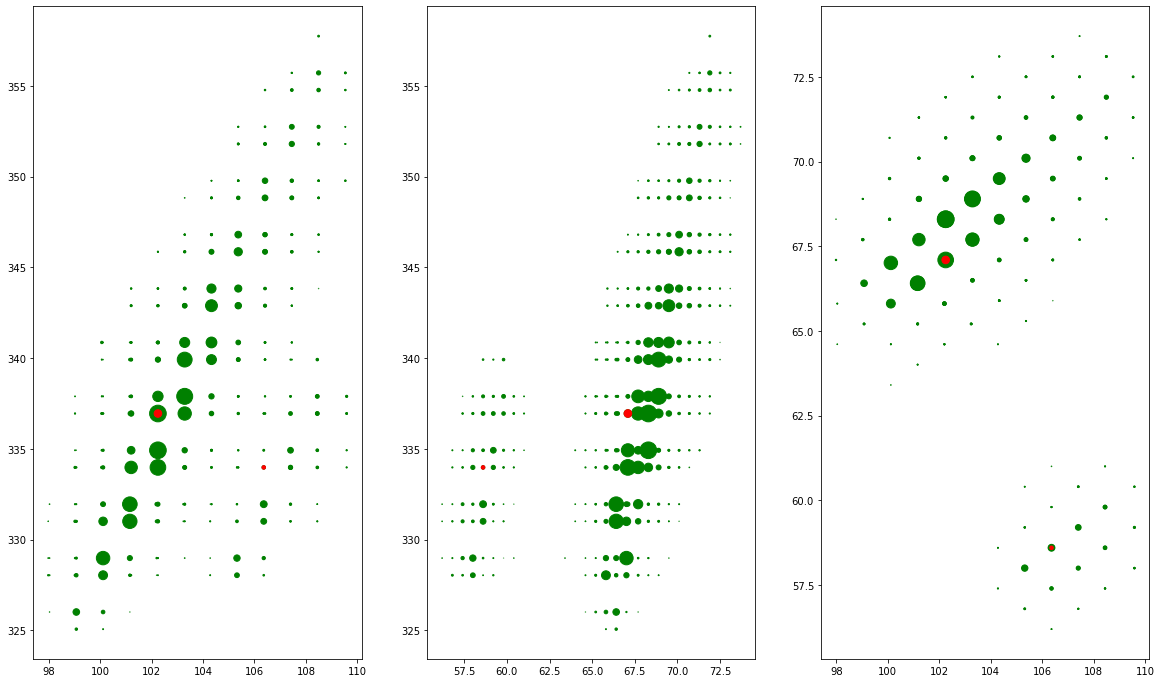

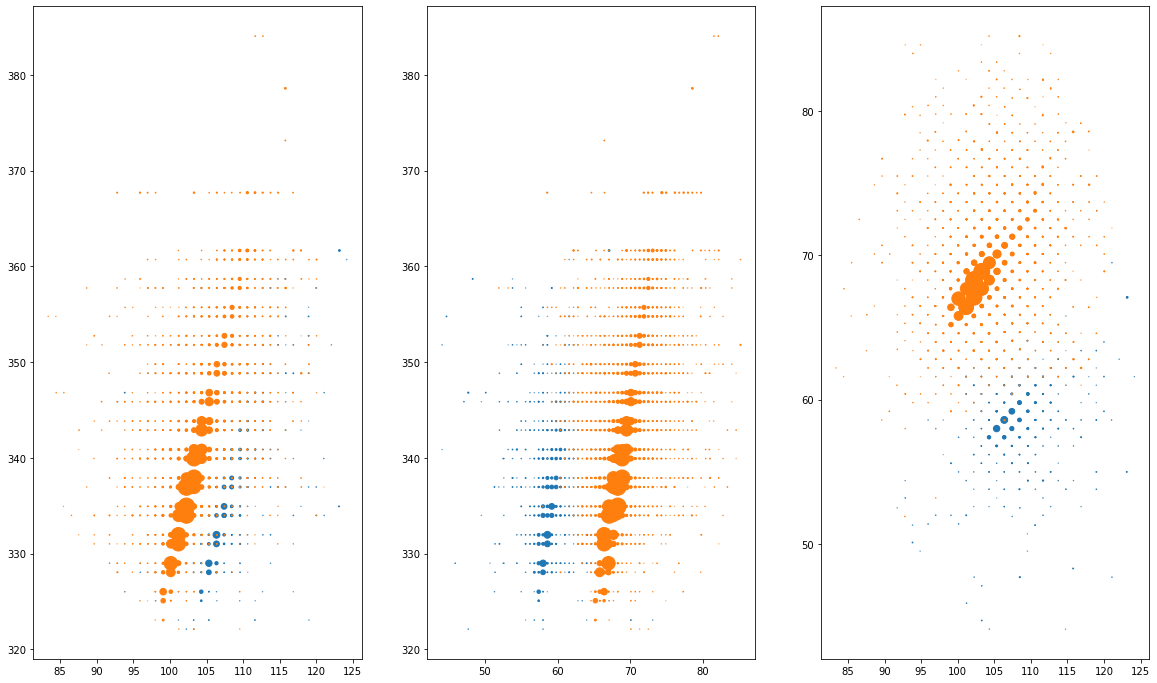

In [13]:
### finally collect objects(seeds+followers)
trksters = {}
for i in tqdm(range(len(seedidxs)),desc="finally building tracksters"):
        idx = []
        for key,val in hitprops.items():
            if key in seedidxs:
                continue
            if val[2] < 0 :
                continue
            if val[2]==seedidxs[i]:
                idx.append(key)
        idx.append(seedidxs[i])
        trksters[i] = idx
    


## plot probable seeds
fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(20,12))
ax0.scatter(hitarray[pseedidxs][:,0],hitarray[pseedidxs][:,2],s=hitarray[pseedidxs][:,3]*10,c='g')
ax1.scatter(hitarray[pseedidxs][:,1],hitarray[pseedidxs][:,2],s=hitarray[pseedidxs][:,3]*10,c='g')
ax2.scatter(hitarray[pseedidxs][:,0],hitarray[pseedidxs][:,1],s=hitarray[pseedidxs][:,3]*10,c='g')
## plot final seeds overlayed on probable seeds
ax0.scatter(hitarray[seedidxs][:,0],hitarray[seedidxs][:,2],s=hitarray[seedidxs][:,3]*10,c='r')
ax1.scatter(hitarray[seedidxs][:,1],hitarray[seedidxs][:,2],s=hitarray[seedidxs][:,3]*10,c='r')
ax2.scatter(hitarray[seedidxs][:,0],hitarray[seedidxs][:,1],s=hitarray[seedidxs][:,3]*10,c='r')

sid = 0
fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(20,12))
for key,val in trksters.items(): ## loop over objects and plot them
    
    print("energy of object:",np.sum(hitarray[val][:,3]))
    ax0.scatter(hitarray[val][:,0],hitarray[val][:,2],s=hitarray[val][:,3]*10)#,c='r')
    ax1.scatter(hitarray[val][:,1],hitarray[val][:,2],s=hitarray[val][:,3]*10)#,c='r')
    ax2.scatter(hitarray[val][:,0],hitarray[val][:,1],s=hitarray[val][:,3]*10)#,c='r')
    '''
    seed = seedidxs[sid]
    #fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(20,12))
    ax0.scatter(hitarray[seed][0],hitarray[seed][2],s=hitprops[seed][1]*1,c='b')
    ax1.scatter(hitarray[seed][1],hitarray[seed][2],s=hitprops[seed][1]*1,c='b')
    ax2.scatter(hitarray[seed][0],hitarray[seed][1],s=hitprops[seed][1]*1,c='b')
    sid +=1
    
    
    #fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(20,12))
    ax0.scatter(hitarray[:,0],hitarray[:,2],s=hitarray[:,3]*1,c='g')
    ax1.scatter(hitarray[:,1],hitarray[:,2],s=hitarray[:,3]*1,c='g')
    ax2.scatter(hitarray[:,0],hitarray[:,1],s=hitarray[:,3]*1,c='g')
    '''






## To think about:
### Do these parameters work for all events? Correct tuning?
### Even harder problem for 2 photons 5 cms apart
### Best of luck!